In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.derivative import parameter_shift

from qaml_scripts.evolution import generate_adiabatic
from qaml_scripts.training import train_adiabatic_evolution
from qaml_scripts.rotational_circuit import rotational_circuit

set_backend("numpy")

[Qibo 0.1.14|INFO|2023-07-31 13:42:55]: Using numpy backend on /CPU:0


# Determining probability density functions with adiabatic quantum computing 

Our goal is to fit Probability Density Functions (PDFs). In a few words, we want a model which, given data $x$ sampled 
from a distribution $\rho$,
returns an estimation of the PDF: $\hat{\rho}(x)$.
For doing this, we start by fitting the Cumulative Density Function (CDF) $F$ of the sample and then we compute the PDF as derivative of the CDF (as it is defined).

We start by considering an adiabatic evolution as machine learning model to fit the CDF, and then we translate the evolution into a corresponding quantum circuit. This procedure allows us to calculate the derivative of the predictor using the Parameter Shift Rule [1].

The whole strategy can be summarized with the following scheme:
<img src="images/pdf_est.png" width="600" height="600" align="center"/>

> In this example we focus on one-dimensional PDFs, and we rely on the results of Ref. [2].

## 2. Adiabatic Evolution in a nutshell

Considering a quantum system set to be in an initial configuration described by $H_0$, 
we call adiabatic evolution (AE) of the system from $H_0$ to $H_1$ an adiabatic
process governed by the following hamiltonian:
$$ H_{\rm ad}(\tau; \vec{\theta}) = \bigl[1 - s(\tau; \vec{\theta})\bigr] H_0 + 
s(\tau; \vec{\theta}) H_1,$$
where we define $s(\tau; \vec{\theta})$ scheduling function of the evolution. According
to the _adiabatic theorem_, if the process is slow enough, the system remains in
the groundstate of $H_{\rm ad}$ during the evolution.

A first simpler example of adiabatic evolution with `Qibo` can be found [here](https://github.com/qiboteam/qibo/tree/master/examples/adiabatic).

#### We select a polynomial scheduling

As scheduling function we are going to use a polynomial function of the form:
$$ s(\tau; \vec{\theta}) = \frac{1}{\Theta} \sum_{k=0}^{N_{\rm params}} \theta_k x^k, 
\qquad \text{with} \qquad \Theta = \sum_{k=1}^{N_{\rm params}} \theta_k,$$
in order to satisfy the computational condition $s(0)=0$ and $s(1)=1$.

## 3. Adiabatic Evolution as tool for encoding CDFs

We encode the CDF of the sample into the energy of a target observable during an adiabatic evolution. This kind of approach can be useful because, when fitting a CDF, we need to 
satisfy some conditions:

1. the CDF is strictly monotonic;
2. $M(x_a) = 0$ and $M(x_b)=1$, with $x_a$ and $x_b$ limits of the random variable 
   $x$ domain.

### Inducing monotonoy

Regarding the first point, as heuristic consideration we can think that an adiabatic 
process is naturally led to follow a "monotonic" behaviour. In particular, if the 
coefficients of the scheduling function are **positive**, we induce the process to 
be monotonic. 

### Exploiting the boundaries 

Secondly, by selecting two hamiltonians $H_0$ and $H_1$ whose energies on the ground state 
satisfy our boundary conditions, we can easily contrain the problem to our desired
requirements.

At this point, we can track the expected value of some target observable $E$ during the evolution. 

> __The goal:__ we perform the mapping: $(x_j, F_j) \to (\tau_j, E_j)$ and we train the
> evolution to let energies pass through our training points ${F_j}$. 

### Adiabatic Evolution settings in this problem

We need to define an adiabatic evolution in which encoding a Cumulative Density
Function. We need to set the energy boundaries to $E(0)=0$ and $E(1)=1$.

For doing this, we set $H_0=\hat{X}$ and $H_1=\hat{Z}$. Then we set a Pauli $\hat{Z}$ to be 
the target observable whose energy is tracked during the evolution:

In [17]:
hx = hamiltonians.X(nqubits=1)
hz = hamiltonians.Z(nqubits=1)

print(f"Expectation of Z over the ground state of a Z: {hz.expectation(hx.ground_state())}")
print(f"Expectation of Z over the ground state of a Z: {hz.expectation(hz.ground_state())}")

Expectation of Z over the ground state of a Z: 0.0
Expectation of Z over the ground state of a Z: -1.0


## 4. Set the Adiabatic Evolution 

The next step is to define some parameters of the evolution, such as the timestep, the final time, etc.

In [13]:
# Definition of the Adiabatic evolution

nqubits = 1
finalT = 50
dt = 1e-1

# rank of the polynomial scheduling
nparams = 15

# set hamiltonianas
h0 = hamiltonians.X(nqubits, dense=True)
h1 = hamiltonians.Z(nqubits, dense=True)
# we choose a target observable
obs_target = h1

# ground states of initial and final hamiltonians
gs_h0 = h0.ground_state()
gs_h1 = h1.ground_state()

# energies at the ground states
e0 = obs_target.expectation(gs_h0)
e1 = obs_target.expectation(gs_h1)

print(f"Energy at 0: {e0}")
print(f"Energy at 1: {e1}")

# initial guess for parameters
# picking up from U(0,1) helps to get the monotony
init_params = np.random.uniform(0, 1, nparams)

# Number of steps of the adiabatic evolution
nsteps = int(finalT/dt)

# array of x values, we want it bounded in [0,1]
xarr = np.linspace(0, 1, num=nsteps+1, endpoint=True)
print("\nFirst ten evolution times:")
print(xarr[0:10])

Energy at 0: 0.0
Energy at 1: -1.0

First ten evolution times:
[0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018]


In the `qaml_scripts/evolution.py` script, a function is defined to generate an `AdiabaticEvolution` object in which we set the polynomial scheduling parameters to be equal to some `init_params` set.

In [5]:
# generate an adiabatic evolution object and an energy callbacks container
evolution, energy = generate_adiabatic(h0=h0, h1=h1, obs_target=obs_target, dt=dt, params=init_params)
# evolve until final time
_ = evolution(final_time=finalT)

### Some useful plotting functions

In [43]:
def plot_energy(times, energies, title, cdf=None):
    """
    Plot -E of the target Z observable moving from h0 to h1.
    If cdf is not None, we also compare -E with the target CDF values.
    """
    plt.figure(figsize=(8,5))
    plt.plot(times, -np.array(energies), color="purple", lw=2, alpha=0.8, label="Energy callbacks")
    if cdf is not None:
        plt.plot(times, -np.array(cdf), color="orange", lw=2, alpha=0.8, label="Empirical CDF")
    plt.title(title)
    plt.xlabel(r'$\tau$')
    plt.ylabel("E")
    plt.grid(True)
    plt.legend()
    plt.show()

def show_sample(times, sample, cdf, title):
    """Plot data sample and its empirical CDF."""
    plt.figure(figsize=(8,5))
    plt.hist(sample, bins=50, color="black", alpha=0.3, cumulative=True, density=True, label="Sample")
    plt.plot(times, -cdf, color="orange", lw=2, alpha=0.8, label="Target CDF")
    plt.title(title)
    plt.xlabel(r'$\tau$')
    plt.ylabel("CDF")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_final_results(times, sample, e, de, title):
    """Plot final results."""
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.title("PDF histogram")
    plt.hist(sample, bins=40, color="orange", histtype="stepfilled", edgecolor="orange", hatch="//", alpha=0.3, density=True)
    plt.hist(sample, bins=40, color="orange", alpha=1, lw=1.5, histtype="step", density=True)
    plt.plot(times, de, color="purple", lw=2, label=r"Estimated $\rho$")
    plt.xlabel('x')
    plt.ylabel(r"$\rho$")
    plt.legend()

    plt.subplot(1,2,2)
    plt.title("CDF histogram")
    plt.hist(sample, bins=40, color="orange", histtype="stepfilled", edgecolor="orange", hatch="//", alpha=0.3, density=True, cumulative=True)
    plt.hist(sample, bins=40, color="orange", alpha=1, lw=1.5, histtype="step", density=True, cumulative=True)
    plt.plot(times, -np.array(e), color="purple", lw=2, label=r"Estimated $F$")
    plt.xlabel('x')
    plt.ylabel(r"$F$")
    plt.legend()

    plt.tight_layout()
    plt.show()

We can have a look to the expected value of the target $\hat{Z}$ Hamiltonian during the random initialized adiabatic evolution.

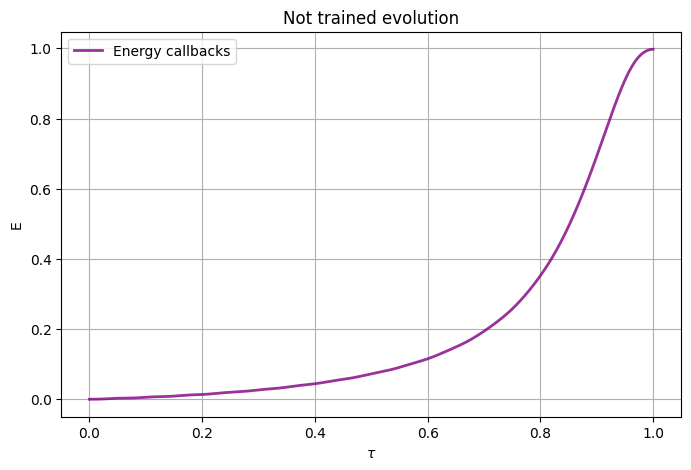

In [32]:
plot_energy(xarr, energy.results, "Not trained evolution")

## 5. Sample from a distribution

We sample a target dataset from a Gamma distribution.

In [33]:
def cdf_fun(xarr):
    """
    Generate a sample of data following a Gamma distribution with shape=10 and scale=0.5.
    The sample is then used to build an histogram whose nbins is equal to the nsteps of the
    evolution. We need to do this in order to map the x into the evolutionary times t.
    
    Args:
        xarr (np.array): times;
    
    Returns:
        cdf: cdf values associated to times;
        sample: data sample not normalised into the range [0,1];
        normed_sample: data sample normalised into the range [0,1].
    """
    
    nvals = 10000
    shape = 10
    scale = 0.5
    
    sample = np.random.gamma(shape, scale, nvals)
    normed_sample = (sample - np.min(sample)) / (np.max(sample) - np.min(sample)) 

    h, b = np.histogram(normed_sample, bins=nsteps, range=[0,1], density=False)
    # Sanity check
    np.testing.assert_allclose(b, xarr)

    cdf_raw = np.insert(np.cumsum(h)/len(h), 0, 0)

    # Translate the CDF such that it goes from 0 to 1
    cdf_norm = (cdf_raw - np.min(cdf_raw)) / (np.max(cdf_raw) - np.min(cdf_raw))
    # And now make it go from the E_initial to E_final (E0 to E1)
    cdf = e0 + cdf_norm*(e1 - e0)

    return cdf, sample, normed_sample

In [34]:
cdf, sample, normed_sample = cdf_fun(xarr)

### A look to the CDF

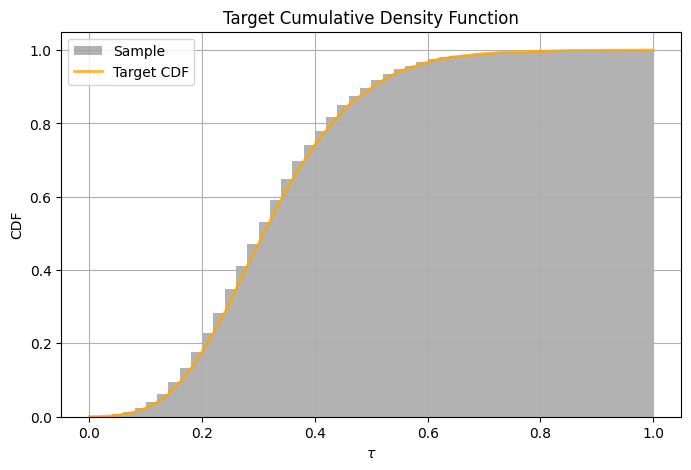

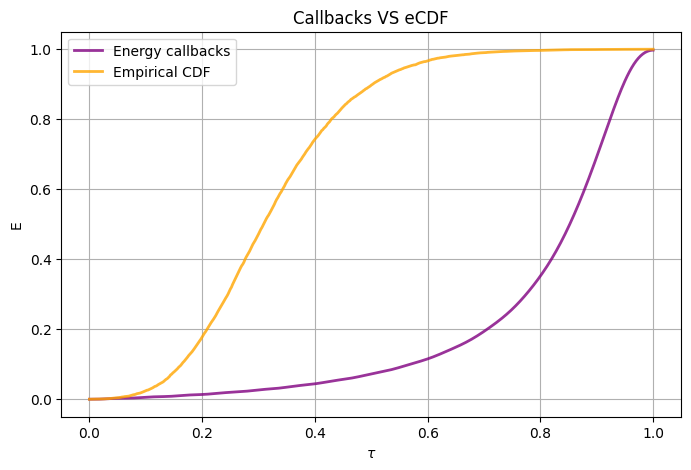

In [35]:
# we plot sample and empirical CDF
show_sample(times=xarr, sample=normed_sample, cdf=cdf, title="Target Cumulative Density Function")
# we plot CDF and (-energy) of the target observable during the non-trained evolution
plot_energy(times=xarr, energies=energy.results, title="Callbacks VS eCDF", cdf=cdf)

## 6. Train the evolution to follow the CDF

The training procedure is the following:

1. we fill the scheduling with a set of parameters;
2. we perform the evolution with the defined set of parameters and we collect all the energies $\{E_k\}_{k=1}^{N_{\rm data}}$, where $E_k$ is the expected value of Z over the evolved state at $\tau_k \equiv x_k$.
3. we calculate a loss function:
   $$ J_{\rm mse} = \frac{1}{N_{\rm data}} \sum_{k=1}^{N_{\rm data}} \bigl[E_k - F(x_k)\bigr]^2. $$
4. we use the CMA-ES optimizer to find the best set of parameters of the scheduling which lead the energy of Z to pass through
   the CDF values.
   
> The following cell takes some minutes to be computed. 
> All the training procedure can be found in the `qaml_script/training.py` script.

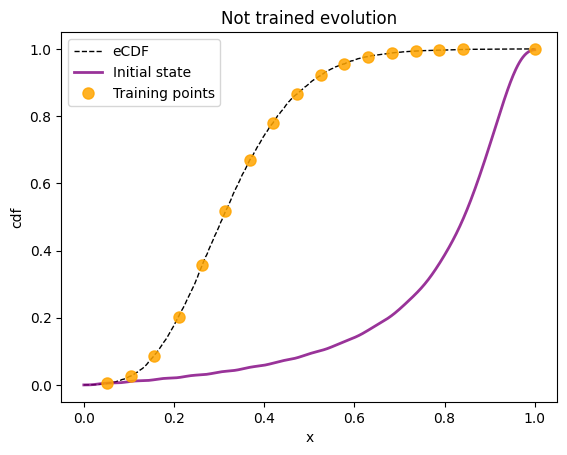

Training on 17 points of the total of 500
Reusing previous best parameters
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 6.609329424041481e-02 1.0e+00 1.61e+00  2e+00  2e+00 0:00.8
    2     24 7.491483294146274e-02 1.1e+00 1.55e+00  2e+00  2e+00 0:01.6
    3     36 8.512073615805898e-02 1.2e+00 1.44e+00  1e+00  2e+00 0:02.5
    7     84 1.054656149048312e-01 1.5e+00 1.65e+00  2e+00  2e+00 0:05.7
   12    144 5.713344493033991e-02 1.9e+00 2.16e+00  2e+00  2e+00 0:09.8
   19    228 4.798973921880101e-02 2.4e+00 2.80e+00  2e+00  3e+00 0:15.5
   27    324 4.494600871473839e-02 3.3e+00 2.89e+00  2e+00  3e+00 0:22.0
   36    432 3.828896215012124e-02 4.3e+00 4.32e+00  4e+00  5e+00 0:29.3
   46    552 1.717985656290756e-02 5.3e+00 5.89e+00  5e+00  8e+00 0:37.4
   58    696 1.184467478922581e-02 8.0e+00 6.14e+00  5e+00  9e+00 0:47.2
   71    852 6.486786453612226e-03 1.1e+01 4.87e+00  4e+00  8e+00 0:57.7
   85   1020 5.494133269030308e-03 1.6e+01 4.34e+0

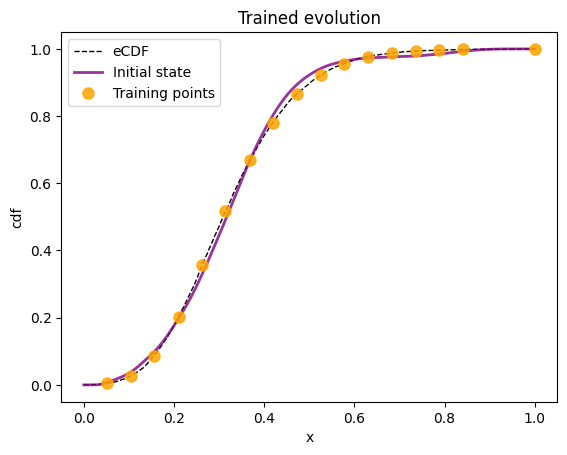

In [47]:
best_params = train_adiabatic_evolution(
    nsteps=nsteps,
    xarr=xarr,
    cdf=cdf,
    training_n=20,
    init_params=init_params,
    e0=e0,
    e1=e1,
    target_loss=1e-3,
    finalT=finalT,
    h0=h0,
    h1=h1,
    obs_target=obs_target
)

## 7. From Adiabatic Evolution to a quantum circuit

We define an unitary operator which can be used to get the evolved state at any 
evolution time $\tau$ thanks to some calculations on the evolution operator
associated to $H_{\rm ad}$. This operator is translated into a circuit composed 
of some rotations in `qaml_scripts/rotational_circuit.py`.

> If we are able to translate the problem to a VQC composed of rotations, we can
> use the Parameter Shift Rule to derivate it very easily.

In [48]:
rotcirc = rotational_circuit(best_p=best_params, finalT=finalT)

In [49]:
# a look to the circuit
# this circuit must be filled with a time value to be well defined

circ1 = rotcirc.rotations_circuit(t=0.1)
circ2 = rotcirc.rotations_circuit(t=0.8)

print(f"Circuit diagram: {circ1.draw()}")
print(f"\nCirc1 params: {circ1.get_parameters()}")
print(f"\nCirc2 params: {circ2.get_parameters()}")

Circuit diagram: q0: ─RZ─RX─RZ─RZ─RZ─RX─RZ─RX─RZ─M─

Circ1 params: [(0.00045531799358689007,), (0.20000960479244062,), (-0.00044624108017310427,)]

Circ2 params: [(-0.00018573270144739418,), (1.600129455712294,), (-5.447340081898844e-06,)]


### Calculate derivative of the circuit with respect to $\tau$

Here we use the parameter shift rule to compute the derivatives of the circuit with respect to the target variables. We need to combine the PSR (which calculates the derivative with respect to the rotational angles) with the analytical derivative of the angles with respect to the time $t$ on which they depend. The calculation is non trivial and explicitly shown in [2]; here we get this derivation calling the `rotcirc.derivative_rotation_angles` method implemented in `qaml_scripts/rotational_circuit.py`.

In [50]:
def psr_energy(t, nshots=None):
    """Calculate derivative of the energy with respect to the real time t."""

    c = rotcirc.rotations_circuit(t)
    dd1, dd2, dd3 = rotcirc.derivative_rotation_angles(t)

    d1 = dd1 * parameter_shift(circuit=c, parameter_index=0, hamiltonian=obs_target, nshots=nshots)
    # looking inside the circuit you will see the second angle is filled with a "-" before
    d2 = - dd2 * parameter_shift(circuit=c, parameter_index=1, hamiltonian=obs_target, nshots=nshots)
    d3 = dd3 * parameter_shift(circuit=c, parameter_index=2, hamiltonian=obs_target, nshots=nshots)

    return (d1 + d2 + d3)

### Calculate derivatives time by time

As final step, we loop over the target times and we calculate both the energy of the observable (the CDF) and its derivative (the PDF).

In [51]:
nshots = 1000
real_times = np.linspace(0, finalT, len(xarr))

de = []
e = []

# loop over times
for t in real_times:
    c = rotcirc.rotations_circuit(t)
    exp = obs_target.expectation(c.execute(nshots=nshots).state())
    # to avoid numerical instabilities when close to zero
    if exp > 0:
        e.append(-exp)
    else:
        e.append(exp)
    de.append(psr_energy(t))

de = - np.asarray(de)*finalT

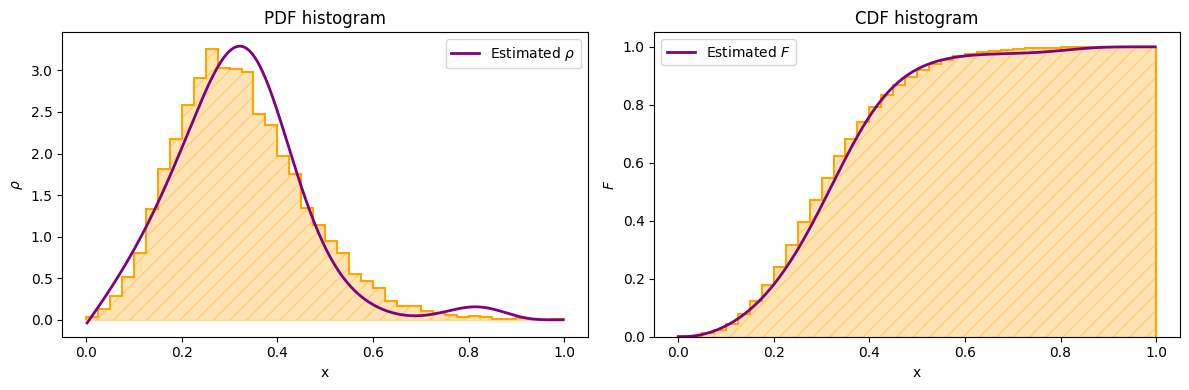

In [52]:
plot_final_results(times=xarr, sample=normed_sample, e=e, de=de, title="Final estimations")

As you can see, even with a small training, the evolutionary model (right plot) starts to learn the shape of the empirical CDF, and its derivative approximates the PDF function. Some better results can be obtained by setting a smaller target value of the loss function when training the adiabatic evolution. 

#### References

[1] [_Evaluating analytic gradients on quantum hardware_, 2018](https://arxiv.org/abs/1811.11184)

[2] [_Determining probability density functions with adiabatic quantum computing_, 2023](https://arxiv.org/abs/2303.11346)